<a href="https://colab.research.google.com/github/apoorvaKR12695/face-emotion-detection-/blob/main/face_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.1 Project Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.
Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.
In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

**1.2 Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.
The solution to this problem is by recognizing facial emotions.

**1.2.1 Face Emotion Recognition**

This is a few shot learning live face emotion detection system. The model should be able to real-time
identify the emotions of students in a live class.

# Importing all required libraries and load the data

In [1]:
# Importing all the required Libraries
import pandas as pd
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential                                                            
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np 
import cv2
import os

# Removing Warnings

import warnings                                                                                
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/') # access the google drive files

Mounted at /content/drive/


In [4]:
# importing zip file from my google drive and extracted it here.
from zipfile import ZipFile
filename = '/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/dataset/archive.zip'

# extract it
with ZipFile(filename , 'r') as zip:
  zip.extractall()
  print('Zip file extracted successfully')

Zip file extracted successfully


In [5]:
#test and train data
test_data = '/content/test/'
train_data = '/content/train/'

In [6]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='Blues_r') 

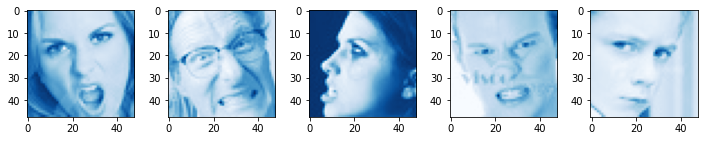

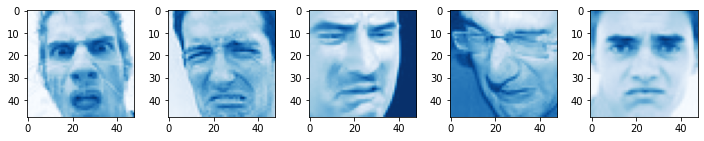

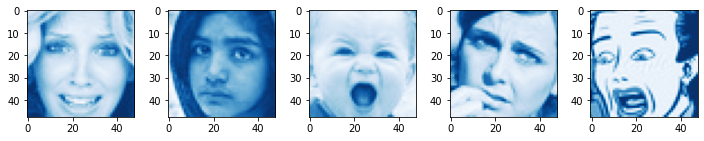

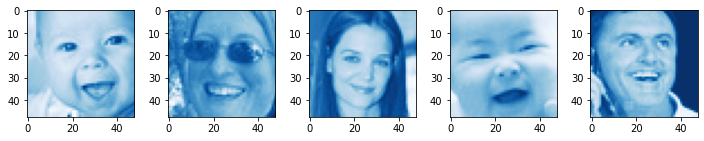

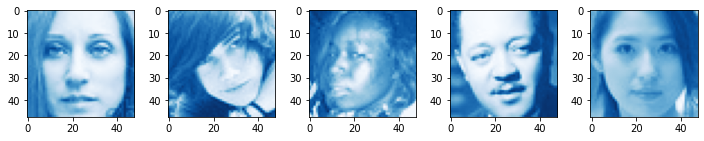

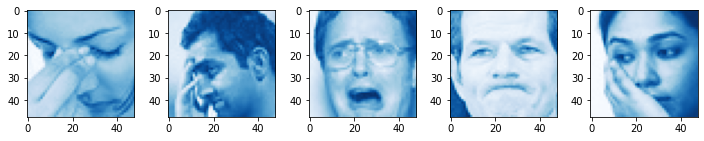

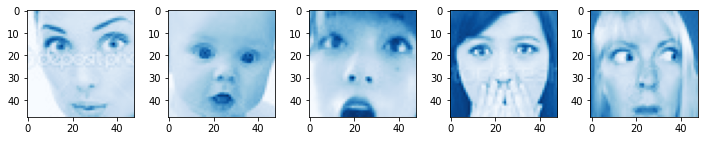

In [7]:
import os
import matplotlib.pyplot as plt
#angry class
plot_images(train_data+'/angry')
#disgust class
plot_images(train_data+'/disgust')
#fear class
plot_images(train_data+'/fear')
#happy class
plot_images(train_data+'/happy')
#neutral class
plot_images(train_data+'/neutral')
#sad class
plot_images(train_data+'/sad')
#surprise class
plot_images(train_data+'/surprise')

# ResNet

The ResNet-50 model consists of 5 stages each with a convolution and Identity block. Each convolution block has 3 convolution layers and each identity block also has 3 convolution layers. The ResNet-50 has over 23 million trainable parameters.

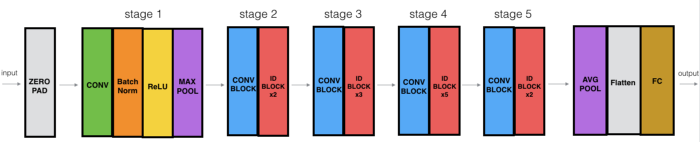

In [8]:
#using pretrained model, RESNET50 architecture
from tensorflow.keras.applications.resnet50 import ResNet50

In [9]:
# ImageDataGenerator Generate batches of tensor image data with real-time data augmentation.
# resnet is trained on rgb photos and we have grascaled images so converting colour mode to rgb
datagen_train = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)
datagen_validation = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)

In [10]:
# size of image and batchs

dim = 48         
batch_size = 32       
 #separate directory for training and a separate directory for validation images

train_generator = datagen_train.flow_from_directory(train_data,
                                                  target_size=(dim,dim),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

validation_generator = datagen_train.flow_from_directory(test_data,
                                                  target_size=(dim,dim),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
# creating a base model using resnet 
# and loading the pretrained weights 
base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')
base_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                          

In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, we should set this parameter to False, indicating that this layer should not be trained. After that, we go over each layer and select which layers we want to train

In [13]:
# making all the layers except last 4 layers non trainable 
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [14]:
# Build model on the top of base model

epochs=50
batch_size = 32 


model1 = Sequential()

model1.add(base_model)
model1.add(Dropout(0.3))
model1.add(Flatten())
model1.add(BatchNormalization())

#Fully connected 1st layer
model1.add(Dense(512,activation = 'relu',kernel_initializer='he_normal'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))


# Fully connected layer 2nd layer
model1.add(Dense(256,activation = 'relu',kernel_initializer='he_normal'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

#output layer
model1.add(Dense(7, activation='softmax'))


# Final model summary
model1.summary()


# compiling the model
model1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])


steps_per_epoch=train_generator.n//train_generator.batch_size

validation_steps=validation_generator.n//validation_generator.batch_size


# this decreases the learning rate if the model loss does not decrease 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001, mode='auto')



# to save model weights to my drive loaction
weight_checkpoint_path = '/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output/resnet_model.h5'

#The ModelCheckpoint callback is flexible in the way it can be used, but in this case, we will use it only to save the best model observed during training as defined by a chosen performance measure on the validation dataset.
checkpoint = ModelCheckpoint(weight_checkpoint_path, monitor='val_accuracy',save_weights_only=True, mode='max', verbose=1)

#Keras supports the early stopping of training via a callback called EarlyStopping.
early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)
callbacks = [checkpoint, reduce_lr,early_stopping]


# Fitting the model 
history = model1.fit(
    x=train_generator,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = validation_generator,
    callbacks=callbacks,
    verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

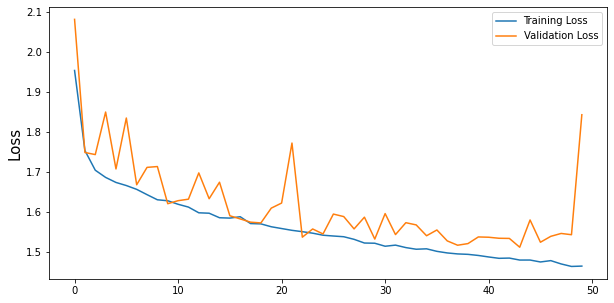

In [15]:
#Plotting Accuracy & Loss

plt.figure(figsize=(10,5))
plt.ylabel('Loss', fontsize=15)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')




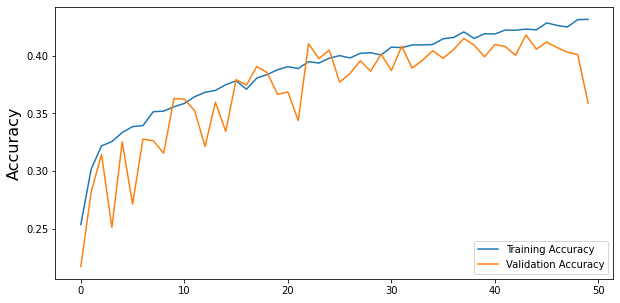

In [16]:
plt.figure(figsize=(10,5))
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

as we can see that training accuracy and validation accuracy is very low so our pretrained model resnet50 is not performing well

# CNN model

 **METHOD 1**:The model uses 32 filters stacked one after the other and each filter has the dimension 3x3. Thus, the model will learn 3x3x32 

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# Creating Image generators, for all train, validation, and test set
training_gen=ImageDataGenerator(rescale=1./255)
testing_gen=ImageDataGenerator(rescale=1./255)
# Creating  Training Dataset
train_gen=training_gen.flow_from_directory(train_data,                
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')

# Creating Test Set
test_gen=testing_gen.flow_from_directory(test_data,                                       
                                           target_size=(48,48),  
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False)

model2 = Sequential()


model2.add(Conv2D(32,(3,3),activation = 'relu',input_shape = (48,48,1)))
#Here the layer reduces the input image by half in width and height.
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Conv2D(64,(3,3),activation = 'relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(64,(3,3),activation = 'relu'))
model2.add(Flatten())
model2.add(Dense(64,activation = 'relu'))
#The final layer of the model will be a fully connected layer with dimensions equal to categories of the classification problem.
model2.add(Dense(7,activation = 'relu'))
  
  

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
model2.compile(loss='categorical_crossentropy',
              optimizer =  tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

# this decreases the learning rate if the model loss does not decrease 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001, mode='auto')



# to save model weights to my drive loaction
weight_checkpoint_path = '/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output'

checkpoint = ModelCheckpoint(weight_checkpoint_path, monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)
callbacks = [checkpoint, reduce_lr,early_stopping]
 #fitting the model

results = model2.fit_generator(generator=train_gen,
                              epochs=50,
                              validation_data = test_gen,
                              callbacks= callbacks
                                )



Epoch 1/50
895/898 [============================>.] - ETA: 0s - loss: 3.1258 - accuracy: 0.2523
Epoch 1: saving model to /content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output
898/898 [==============================] - 13s 13ms/step - loss: 3.1211 - accuracy: 0.2523 - val_loss: 1.9351 - val_accuracy: 0.2647 - lr: 0.0010
Epoch 2/50
897/898 [============================>.] - ETA: 0s - loss: 1.9447 - accuracy: 0.2732
Epoch 2: saving model to /content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output
898/898 [==============================] - 12s 13ms/step - loss: 1.9444 - accuracy: 0.2732 - val_loss: 1.9307 - val_accuracy: 0.3016 - lr: 0.0010
Epoch 3/50
897/898 [============================>.] - ETA: 0s - loss: 1.9326 - accuracy: 0.2786
Epoch 3: saving model to /content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output
898/898 [==============================] - 12s 13ms/step - loss: 1.9324 - accuracy: 0.2786 - val_lo

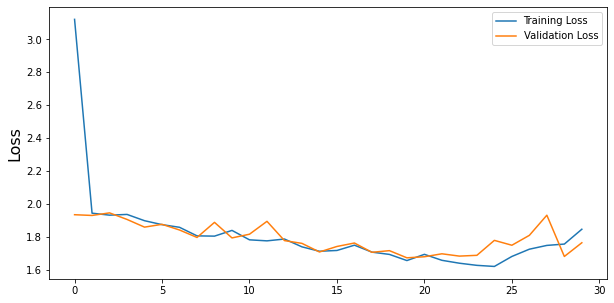

In [19]:
#Plotting Accuracy & Loss

plt.figure(figsize=(10,5))
plt.ylabel('Loss', fontsize=16)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')




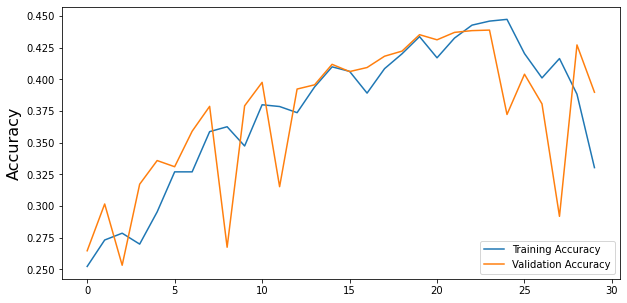

In [20]:
plt.figure(figsize=(10,5))
plt.ylabel('Accuracy', fontsize=16)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**Analyzing the Model Performance**

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Predicting For Test Set
predictions=model2.predict(test_gen)

# Printing Confution Matrix
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)                         
cm

array([[ 134,    0,   47,  278,  240,  192,   67],
       [  18,    0,   11,   30,   33,   12,    7],
       [  62,    0,   88,  244,  238,  223,  169],
       [  39,    0,   40, 1376,  123,  143,   53],
       [  46,    0,   27,  294,  615,  196,   55],
       [  83,    0,   59,  304,  319,  424,   58],
       [  23,    0,   43,  104,  103,   71,  487]])

In [22]:
 from sklearn.metrics import accuracy_score

 # Accuracy Score of Our Model
acc=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=test_gen.classes)
acc 

0.4352187238785177

Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.33      0.14      0.20       958
     disgust       0.00      0.00      0.00       111
        fear       0.28      0.09      0.13      1024
       happy       0.52      0.78      0.62      1774
     neutral       0.37      0.50      0.42      1233
         sad       0.34      0.34      0.34      1247
    surprise       0.54      0.59      0.56       831

    accuracy                           0.44      7178
   macro avg       0.34      0.35      0.33      7178
weighted avg       0.40      0.44      0.40      7178



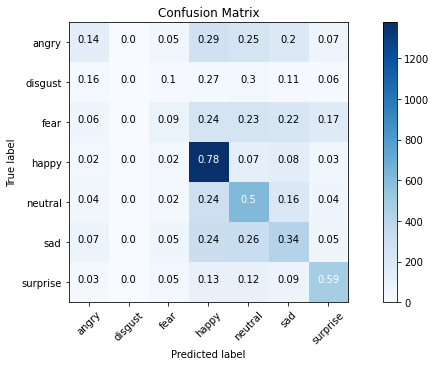

In [23]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model2.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

 the model did not perform well on the validation data and training data. Thus, we will move ahead and make amendments to the parameters.

# **Method2 :CNN model with dropout and batchnormalization**

**1.Add Dropout layer**

During the training of the model, we observed that accuracy on training data was much much higher than that of validation. This is a classic sign that the model is overfitted. We need to generalize it to work better on unseen data. The dropout layer sets specific inputs to 0. This helps reduce dependency on any particular set of inputs, thereby removing the significance of those in the training process. It would be used only at the time of training. 

**2.Add Batch Normalization**

This layer helps the model converge faster and does not improve accuracy. This can be thought of as a process of standardization where input variance is reduced. 

In [77]:
 #epochs are the number of iterations in which training takes place. In each iteration, a limited number of images are passed to the model in batches (defined as batch_size).
 epochs = 100

In [78]:
num_labels = 7
model3 = Sequential()  
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1), padding='same'))  
model3.add(Conv2D(64,kernel_size= (3, 3), activation='relu', padding='same'))  
model3.add(BatchNormalization())  
model3.add(MaxPooling2D(pool_size=(2,2)))  
model3.add(Dropout(0.3))  
#2nd convolution layer  
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  
model3.add(BatchNormalization())  
model3.add(MaxPooling2D(pool_size=(2,2)))  
model3.add(Dropout(0.3))  
#3rd convolution layer  
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))  
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))  
model3.add(BatchNormalization())  
model3.add(MaxPooling2D(pool_size=(2,2)))  
model3.add(Dropout(0.3))
#3rd CNN layer
model3.add(Conv2D(512,(3,3),activation='relu',padding = 'same'))
model3.add(Conv2D(512, (3, 3), activation='relu', padding='same'))  
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout (0.3))

model3.add(Flatten())  
model3.add(Dense(num_labels, activation='softmax'))  
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 64)       

In [79]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output/cnn_model2.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]



model3.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

 #fitting the model
results = model3.fit(train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=epochs,
                                validation_data = test_gen,
                                validation_steps = test_gen.n//test_gen.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/100
897/897 [==============================] - 20s 22ms/step - loss: 2.2105 - accuracy: 0.2844 - val_loss: 1.6012 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/100
897/897 [==============================] - 19s 21ms/step - loss: 1.6052 - accuracy: 0.4109 - val_loss: 1.5660 - val_accuracy: 0.3952 - lr: 0.0010
Epoch 3/100
897/897 [==============================] - 19s 22ms/step - loss: 1.4126 - accuracy: 0.4725 - val_loss: 1.5326 - val_accuracy: 0.4456 - lr: 0.0010
Epoch 4/100
897/897 [==============================] - 20s 22ms/step - loss: 1.3290 - accuracy: 0.5069 - val_loss: 1.2689 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 5/100
897/897 [==============================] - 20s 22ms/step - loss: 1.2675 - accuracy: 0.5293 - val_loss: 1.2000 - val_accuracy: 0.5460 - lr: 0.0010
Epoch 6/100
897/897 [==============================] - 20s 22ms/step - loss: 1.1765 - accuracy: 0.5642 - val_loss: 1.2710 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 7/100
897/897 [==============================]

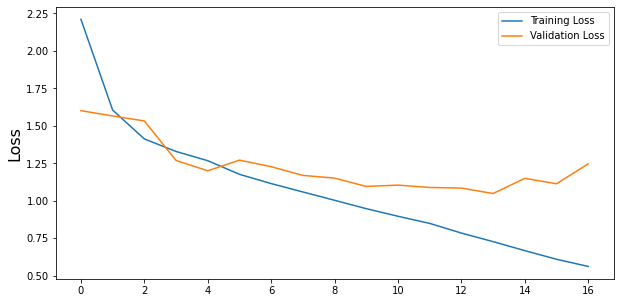

In [80]:
#Plotting Accuracy & Loss

plt.figure(figsize=(10,5))
plt.ylabel('Loss', fontsize=16)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')




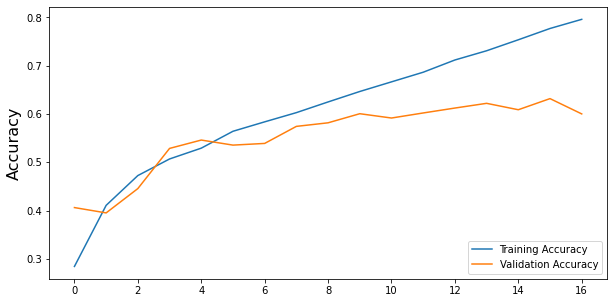

In [81]:
plt.figure(figsize=(10,5))
plt.ylabel('Accuracy', fontsize=16)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

As you can see, both validation and training losses are getting reduced, so we will conclude that our overfitting problem has been resolved.


In [82]:
from sklearn.metrics import confusion_matrix, classification_report

# Predicting For Test Set
predictions=model3.predict(test_gen)

# Printing Confution Matrix
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)                         
cm

array([[ 434,    6,  204,   43,  128,  120,   23],
       [  24,   53,   19,    3,    4,    7,    1],
       [  64,    3,  563,   25,  127,  161,   81],
       [  47,    0,   82, 1452,  103,   43,   47],
       [  52,    1,  119,   92,  781,  177,   11],
       [  99,    1,  268,   78,  230,  555,   16],
       [  15,    0,  104,   33,   37,   13,  629]])

In [83]:
 from sklearn.metrics import accuracy_score

 # Accuracy Score of Our Model
acc=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=test_gen.classes)
acc 

0.622318194483143

Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.59      0.45      0.51       958
     disgust       0.83      0.48      0.61       111
        fear       0.41      0.55      0.47      1024
       happy       0.84      0.82      0.83      1774
     neutral       0.55      0.63      0.59      1233
         sad       0.52      0.45      0.48      1247
    surprise       0.78      0.76      0.77       831

    accuracy                           0.62      7178
   macro avg       0.65      0.59      0.61      7178
weighted avg       0.63      0.62      0.62      7178



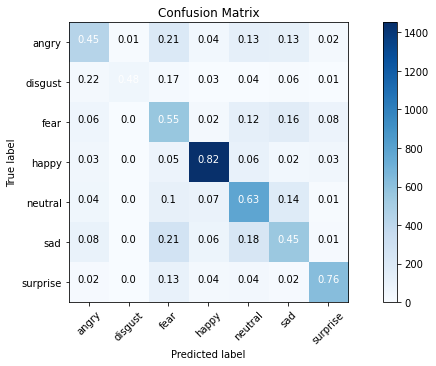

In [84]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model3.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

 The accuracy for the test data(0.62) is less than the accuracy for the training data(0.77),there is still scope for improvement where we can try to reduce the gap between validation and training errors.

# **Method3 :  CNN model with some more hidden layers**

In [32]:
# Creating Image generators, for all train, validation, and test set
training_gen=ImageDataGenerator(rescale=1./255)
testing_gen=ImageDataGenerator(rescale=1./255)

In [53]:
# Creating  Training Dataset
train_gen=training_gen.flow_from_directory(train_data,                
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')

# Creating Test Set
test_gen=testing_gen.flow_from_directory(test_data,                                       
                                           target_size=(48,48),  
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [54]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

no_of_classes = 7

model4 = Sequential()

#1st CNN layer
model4.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu',input_shape = (48,48,1)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(Dropout(0.3))

#2nd CNN layer
model4.add(Conv2D(128,(5,5),activation = 'relu',padding = 'same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(Dropout (0.3))

#3rd CNN layer
model4.add(Conv2D(512,(3,3),activation = 'relu',padding = 'same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(Dropout (0.25))

#4th CNN layer
model4.add(Conv2D(512,(3,3),activation = 'relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

model4.add(Flatten())

# Fully connected layer 
model4.add(Dense(512))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.3))

model4.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model4.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/cnn-model3.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]



model4.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

 #fitting the model

results = model4.fit_generator(generator=train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=50,
                                validation_data = test_gen,
                                validation_steps = test_gen.n//test_gen.batch_size,
                                callbacks=callbacks_list
                                )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 128)     

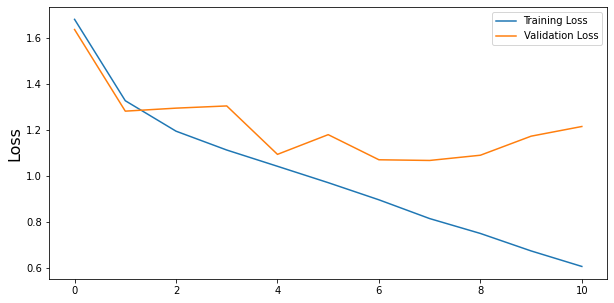

In [55]:
#Plotting Accuracy & Loss

plt.figure(figsize=(10,5))
plt.ylabel('Loss', fontsize=16)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')




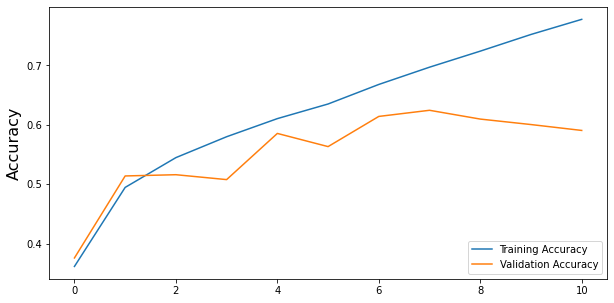

In [56]:
plt.figure(figsize=(10,5))
plt.ylabel('Accuracy', fontsize=16)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

# Predicting For Test Set
predictions=model4.predict(test_gen)

# Printing Confution Matrix
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)                         
cm

array([[ 492,    9,  102,   67,   82,  182,   24],
       [  23,   61,    8,    4,    3,   10,    2],
       [  86,    6,  454,   51,   83,  248,   96],
       [  40,    1,   35, 1504,   78,   86,   30],
       [  81,    0,   88,  110,  648,  282,   24],
       [ 127,    1,  140,  104,  153,  695,   27],
       [  23,    2,   76,   54,   22,   25,  629]])

In [58]:
 from sklearn.metrics import accuracy_score

 # Accuracy Score of Our Model
acc=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=test_gen.classes)
acc 

0.6245472276400111

Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       angry       0.56      0.51      0.54       958
     disgust       0.76      0.55      0.64       111
        fear       0.50      0.44      0.47      1024
       happy       0.79      0.85      0.82      1774
     neutral       0.61      0.53      0.56      1233
         sad       0.45      0.56      0.50      1247
    surprise       0.76      0.76      0.76       831

    accuracy                           0.62      7178
   macro avg       0.63      0.60      0.61      7178
weighted avg       0.63      0.62      0.62      7178



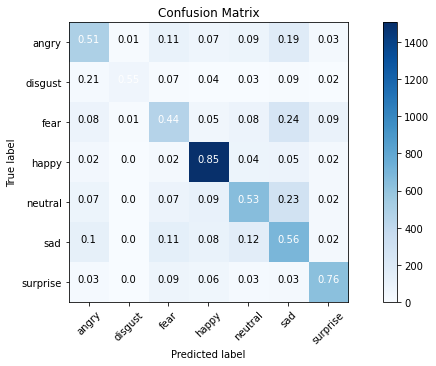

In [60]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model4.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

now our model is performing well ,there is increase in test accuracy from 60% to 62.06%

# webcam

In [61]:
model4.save('/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output/cnn-model3.h5')

In [62]:
from keras.models import model_from_json
model_json = model4.to_json()
with open('/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output/cnn-model3.json', "w") as json_file:
    json_file.write(model_json)

In [63]:

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes




# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [64]:
colour_cycle = ((255, 0, 0), (0, 255, 0), (0, 0, 255), (230, 230, 250))

In [65]:
from keras.models import model_from_json
import numpy as np
import cv2

def load_model(path):

	json_file = open(path + 'cnn-model3.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	
	model = model_from_json(loaded_model_json)
	model.load_weights(path + "cnn-model3.h5")
	print("Loaded model from disk")
	return model
	
def predict_emotion(gray, x, y, w, h):
	face = np.expand_dims(np.expand_dims(np.resize(gray[y:y+w, x:x+h]/255.0, (48, 48)),-1), 0)
	prediction = model.predict([face])

	return(int(np.argmax(prediction)), round(max(prediction[0])*100, 2))

In [67]:
path = "/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/output/"
model = load_model(path)

fcc_path = "/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(fcc_path)
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
colour_cycle = ((255, 0, 0), (0, 255, 0), (0, 0, 255), (230, 230, 250))
# # webcam = cv2.VideoCapture(0)

Loaded model from disk


In [68]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
counter = 1
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30, 30))
    # get face bounding box for overlay
    for (count,(x, y, w, h)) in enumerate(faces):
      colour = colour_cycle[int(count%len(colour_cycle))]
      bbox_array = cv2.rectangle(bbox_array, (x, y), (x+w, y+h), colour, 2)
      bbox_array = cv2.line(bbox_array, (x+5, y+h+5),(x+100, y+h+5), colour, 20)
      bbox_array = cv2.putText(bbox_array, "Face #"+str(count+1), (x+5, y+h+11), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), lineType=cv2.LINE_AA)
      bbox_array = cv2.line(bbox_array, (x+8, y),(x+150, y), colour, 20)
      emotion_id, confidence = predict_emotion(gray, x, y, w, h)
      emotion = emotion_dict[emotion_id]
      bbox_array = cv2.putText(bbox_array, emotion + ": " + str(confidence) + "%" , (x+20, y+5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), lineType=cv2.LINE_AA)
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes      
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break;
# out.release()
# webcam.release()
cv2.destroyAllWindows()  

<IPython.core.display.Javascript object>

# upload pictures

In [69]:
from keras.models import model_from_json
model_json = model4.to_json()
with open("/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/model/model4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model4.save_weights("/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/model/model4.hdf5")
print("Saved model3 to disk")

Saved model3 to disk


In [70]:
# Saving the whole emotion_model along with architecture in FER_model.h5
model4.save('/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/model/FER_model.h5')
print('Model3 Saved')

Model3 Saved


In [71]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()


In [72]:
from keras.models import model_from_json
import numpy as np
import cv2

def load_model(path):

	json_file = open(path + 'model4.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	
	model = model_from_json(loaded_model_json)
	model.load_weights(path + "FER_model3.h5")
	print("Loaded model from disk")
	return model

In [73]:
#model loading
path = "/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/model/"
model = load_model(path)

Loaded model from disk


In [74]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [75]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

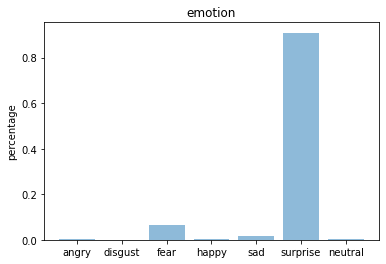

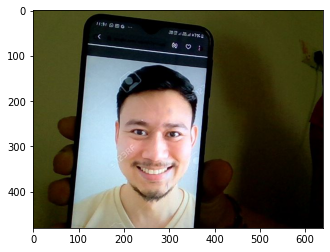

In [76]:
import cv2
            
def facecrop(image):  
    facedata = '/content/drive/MyDrive/Face Emotion recognition/dataset and trained models/haarcascade_frontalface_default.xml' 
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

   


if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = '/content/photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model4.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()


**conclusion**

1.training accuracy and validation accuracy is very low so our pretrained model resnet50 is not performing well

2.We trained the neural network and we achieved the highest training  accuracy of 74.28%. After using test data to check how well our model generalizes, we score an astounding 62.06% on the test set.

3.Successfully deployed the streamlit web app on heroku and streamlit share that runs on a web server 

4.Our model can successfully detect face and predict emotion on live feed as well as on image
